In [1]:
import torch
from torch import nn,optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def visualize(org,decoded,noised):
    fig,axs = plt.subplots(3,20,figsize=(20,3))
    for ax,img in zip(axs[0],org):
        ax.imshow(img,cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    
    for ax,img in zip(axs[1],noised):
        ax.imshow(img,cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        
    for ax,img in zip(axs[2],decoded):
        ax.imshow(img,cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

# Device for Training

In [3]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Loading Data

In [4]:
force = False
training_data = datasets.MNIST('data',train=True,download=force,transform=ToTensor())
test_data = datasets.MNIST('data',train=False,transform=ToTensor())

In [5]:
tmp_steps = 200
print(len(training_data) / 200, len(test_data) / 200)
assert(len(training_data) // tmp_steps * tmp_steps == len(training_data))
assert(len(test_data) // tmp_steps * tmp_steps == len(test_data))

300.0 50.0


In [6]:
steps_per_epoch = 200
train_dataloader = DataLoader(training_data,batch_size=len(training_data) // steps_per_epoch)
test_dataloader = DataLoader(test_data,batch_size=len(test_data) // steps_per_epoch)
# first_data = lambda dataloader : next(iter(dataloader))
print_shape = lambda X,y: print(f"Shape of X [N, C, H, W]: {X.shape}\n"
                                f"Shape of y: {y.shape} {y.dtype}")
print_shape(*next(iter(train_dataloader)))
print_shape(*next(iter(test_dataloader)))

Shape of X [N, C, H, W]: torch.Size([300, 1, 28, 28])
Shape of y: torch.Size([300]) torch.int64
Shape of X [N, C, H, W]: torch.Size([50, 1, 28, 28])
Shape of y: torch.Size([50]) torch.int64


# Model Development

In [18]:
class MNIST_Autoencoder(nn.Module):
    def __init__(self,latent_size=10):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 12, kernel_size=3),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            
            nn.Conv2d(12, 24, kernel_size=6, stride=2),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            
            nn.Conv2d(24, 32, kernel_size=6, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.Flatten(),
        )
        
        self.encoder = nn.Sequential(
            nn.Linear(288, 100, bias=False),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, latent_size, bias=False),
            nn.BatchNorm1d(latent_size),
            nn.ReLU(),
        )
        
        # number of generator filters
        ngf = 64 
        channel_num = 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_size, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf*2,ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf,channel_num, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def encode(self,x):
        x = self.conv(x)
        x = self.encoder(x)
        return x
    
    def decode(self,x):
        x = x.view(x.size(0),-1,1,1)
        return self.decoder(x)
    
    def forward(self,x):
        x = self.encode(x)
        x = self.decode(x)
        return x

model = MNIST_Autoencoder().to(device)
X,_ = next(iter(train_dataloader))
model(X.to(device)).shape
# model

torch.Size([300, 1, 28, 28])

# Add noise

In [8]:
def noising(X, noise_factor = 0.2):
    return torch.randn_like(X)*noise_factor + X

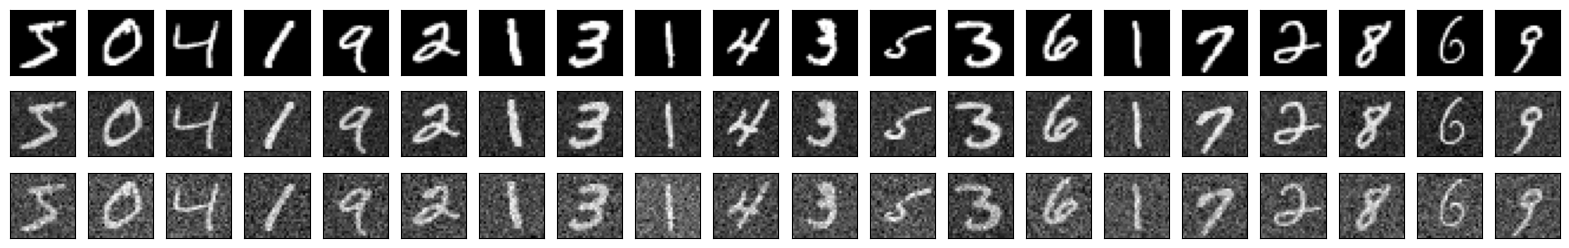

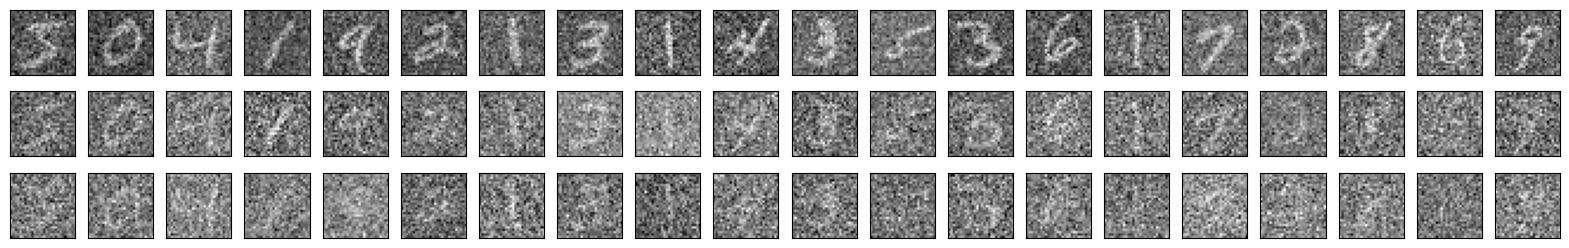

In [9]:
X,_ = next(iter(train_dataloader))
visualize(X.view(-1,28,28),
          noising(X,0.2).view(-1,28,28),
          noising(X,0.1).view(-1,28,28),)
visualize(noising(X,0.4).view(-1,28,28),
          noising(X,1).view(-1,28,28),
          noising(X,0.8).view(-1,28,28),)

# Optimization configuration

In [10]:
# optimization configurations
loss_fn = nn.CrossEntropyLoss()
epochs = 5
max_learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=max_learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr = max_learning_rate,
                                          steps_per_epoch=steps_per_epoch,
                                          epochs=epochs,)

# Develop Optimization Iteration

In [11]:
train_losses = []
test_losses = []

In [12]:
def train(train_dataloader, model, loss_fn, optimizer,scheduler):
    model.train()
    train_loss = 0
    for X,y in train_dataloader:
        X = X.to(device)
        
        
        # Forward pass
        pred = model(noising(X))
        loss = loss_fn(pred.view(pred.size(0),-1), X.view(X.size(0),-1))
        # trace
        train_loss += loss.item()
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    num_batches = len(train_dataloader)
    train_loss /= num_batches
    train_losses.append(train_loss)

In [13]:
def test(dataloader, model, loss_fn):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X,y in dataloader:
            X = X.to(device)
            
            # forward pass
            pred = model(noising(X))
            loss = loss_fn(pred.view(pred.size(0),-1), X.view(X.size(0),-1))
            test_loss += loss.item()
    
    num_batches = len(dataloader)
    test_loss /= num_batches
    test_losses.append(test_loss)

# Run the iteration

Epoch 5
-------------------------------


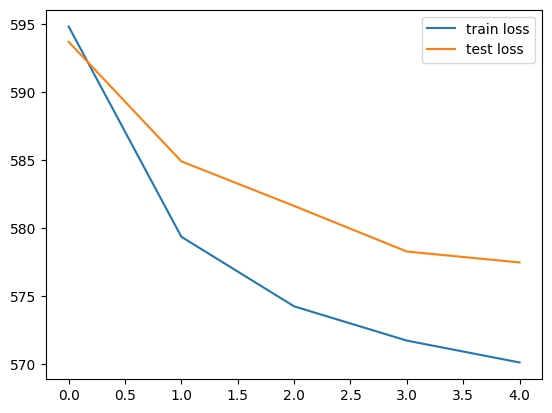

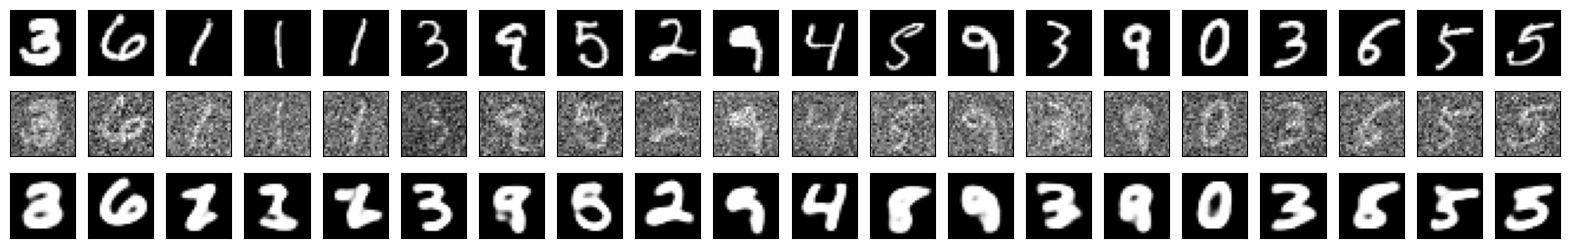

Done!


In [14]:
from IPython.display import clear_output
from itertools import cycle

dat = cycle(test_dataloader)

for t in range(epochs):

    train(train_dataloader,model, loss_fn, optimizer,scheduler)
    test(test_dataloader,model,loss_fn)
    
    with torch.no_grad():
        X,y = next(dat)
        noise_X = noising(X,0.5)
        
        decoded = model(noise_X.to(device)).to('cpu')
        
        # to_img = lambda flat: flat.view(flat.size(0),28,28))
        X = X.view(X.size(0),28,28)
        noise_X = noise_X.view(noise_X.size(0),28,28)
        decoded = decoded.view(decoded.size(0),28,28)
        
        clear_output()
        print(f"Epoch {t+1}\n-------------------------------")
        plt.plot(train_losses,label="train loss")
        plt.plot(test_losses,label="test loss")
        plt.legend()
        visualize(X,decoded,noise_X)
    
print("Done!")

In [19]:
torch.save(model.state_dict(), "model/mnist_autoencoder.pth")
model = MNIST_Autoencoder()
model.load_state_dict(torch.load("model/mnist_autoencoder.pth"))
model.to(device)

MNIST_Autoencoder(
  (conv): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(12, 24, kernel_size=(6, 6), stride=(2, 2))
    (4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(24, 32, kernel_size=(6, 6), stride=(2, 2))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (encoder): Sequential(
    (0): Linear(in_features=288, out_features=100, bias=False)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=10, bias=False)
    (4): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(10, 512

# Example Usage

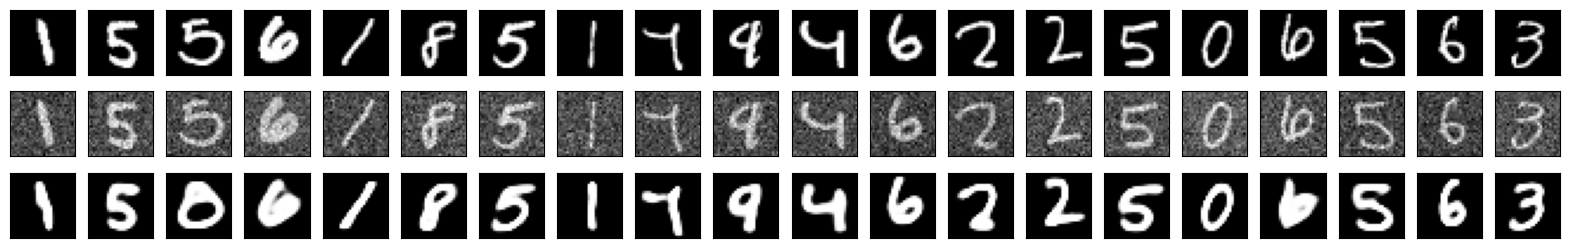

In [20]:
with torch.no_grad():
    X,_ = next(dat)
    noise_X = noising(X,0.2)
    
    code = model.encode(noise_X.to(device))
    decoded = model.decode(code).to('cpu')
    
    noise_X = noise_X.view(noise_X.size(0),28,28)
    X = X.view(X.size(0),28,28)
    decoded = decoded.view(X.size(0),28,28)
    # print(code)
    visualize(X,decoded,noise_X)